In [1]:
import brian2
from brian2tools import *
from brian2 import *
from struct import unpack
from PIL import Image
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import os.path
import pickle as pickle
import scipy
import scipy.signal as signal
import time
import warnings
warnings.simplefilter('ignore')
import gc
gc.collect()

0

In [2]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
#     print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [3]:
def get_stimuli_strip(j, o_index, shape):
    length = shape[0]
    f = 75
    matrix = np.zeros(shape)
    if (o_index == v_index):
        matrix[:,j] += f

    elif (o_index == h_index):
        matrix[j,:] += f

    elif (o_index == d2_index):
        if(j < length):
            for i in range(j + 1):
                matrix[i][j - i] += 1.2*f
        else:
            grid_h = j - length + 1
            grid_v = length - 1
            for i in range(grid_h, length):
                matrix[i][grid_v] += 1.2*f
                grid_v -= 1

    elif (o_index == d1_index):
        if(j < length):
            h_grid = length - 1
            for i in range(j + 1):
                matrix[h_grid][j - i] += 1.2*f
                h_grid -= 1
        else:
            grid_h = 2*(length - 1) - j
            grid_v = length - 1
            for i in range(grid_h, -1, -1):
                matrix[i][grid_v] += 1.2*f
                grid_v -= 1        

    return matrix

In [4]:
def save_connections():
    for connName in connections:
        conn = connections[connName]
        weights = np.column_stack((conn.i, conn.j, conn.w))
        sparseWeights = weights[~(weights.transpose()[2] == 0)]
        np.save(saved_path + connName, sparseWeights)
        print(connName, end=' ')
    print('connections saved')

In [5]:
def get_surrounding(coordinate, r, inner, length):
    y = coordinate[0]
    x = coordinate[1]
    
    x_min = 0 if (x-r < 0) else (x-r)
    x_max = (length-1) if (x+r > length-1) else (x+r)
    y_min = 0 if (y-r < 0) else (y-r)
    y_max = (length-1) if (y+r > length-1) else (y+r)
    
    coordinates = []
    for i in range(y_min, y_max+1):
        for j in range(x_min, x_max+1):
            if (i==y and j==x and not inner):
                continue
            coordinates.append((i,j))
            
    return coordinates

def get_prefered_surrounding(coordinate, o_index, c_length):
    x = coordinate[0]
    y = coordinate[1]
    
    arr = []
    if (o_index == h_index):
        arr = [(x,y-2), (x,y-1), (x,y+1), (x,y+2)]
    elif (o_index == v_index):
        arr = [(x-2,y), (x-1,y), (x+1,y), (x+2,y)]
    elif (o_index == d1_index):
        arr = [(x+2,y-2), (x+1,y-1), (x-1,y+1), (x-2,y+2)]
    elif (o_index == d2_index):
        arr = [(x+2,y+2), (x+1,y+1), (x-1,y-1), (x-2,y-2)]
    
    coordinates = []
    for (p,q) in arr:
        if ((p>-1 and p<c_length) and (q>-1 and q<c_length)):
            coordinates.append((p,q))
    return coordinates

In [6]:
def plot_lateral_distribution(name):
    weights = np.array(connections[name].w)
    weights = weights.reshape(shape)
    
    # init dictionary
    sum_dic = {}
    c = {0:'h', 1:'v', 2:'d1', 3:'d2'}

    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_surrounding((i,j), lateral_range, False, c_length):
                
                for s_index in range(orientations):
                    for t_index in range(orientations):
                        target = ( p * c_length + q ) * orientations + t_index
                        source = ( i * c_length + j ) * orientations + s_index
                        sum_dic[c[s_index]+c[t_index]] += abs(weights[source][target])
                        
    category_names = ['H', 'V', 'Diagonal (45)', 'Diagonal (135)']
    results = { 'h': [], 'v': [], 'd1': [], 'd2': [] }
    %run horizontal_barchart_distribution.py
                        
    for s_index in range(orientations):
        for t_index in range(orientations):
            results[c[s_index]].append(sum_dic[c[s_index]+c[t_index]])

    survey(results, category_names)

In [7]:
def plot_preferred_distribution():
    c = {0:'horizontal', 1:'vertical', 2:'diagonal 45', 3:'diagonal 135'}
        
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape(shape)
    
    # init dictionary
    w_arr = [[], [], [], []]
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for o_index in range(orientations):
                for p,q in get_prefered_surrounding((i,j), o_index, c_length):
                    target = ( p * c_length + q ) * orientations + o_index
                    source = ( i * c_length + j ) * orientations + o_index
                    w_arr[o_index].append(weights[source][target])
                        
    plt.figure(figsize=(17,12))
    for o_index in range(orientations):
        plt.subplot(4, 1, o_index+1)
        plt.plot(w_arr[o_index], label=c[o_index])
        plt.legend()
        print(c[o_index], ' - ', sum(w_arr[o_index]))
    
    plt.show()
    gc.collect()

In [8]:
def normalize_prefered_weights(o_index):
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape((n_L3, n_L3))
    
    penalize_self(weights, (n_L3, n_L3))
    
    w_ar = np.array([])
    
    count = 0;
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_prefered_surrounding((i,j), o_index, c_length):
                target = ( p * c_length + q ) * orientations + o_index
                source = ( i * c_length + j ) * orientations + o_index
                w_ar = np.append(w_ar, weights[source][target])
                count += 1
    print('o_index', o_index,'count',count)
    
    q90 = np.percentile(w_ar, 85)
    q10 = np.percentile(w_ar, 10)
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for p,q in get_prefered_surrounding((i,j), o_index, c_length):
                target = ( p * c_length + q ) * orientations + o_index
                source = ( i * c_length + j ) * orientations + o_index
                if (weights[source][target] > q90):
                    weights[source][target] = q90
                elif (weights[source][target] < q10):
                    weights[source][target] = q10
    
    weights = weights.reshape((n_L3*n_L3))
    connections['L3_L3'].w = weights
    gc.collect()

In [9]:
def penalize_self(weights, shape):
    for i in range(shape[0]):
        weights[i][i] *= 0.5
    return weights

In [10]:
def change_weights(update_value):
    shape = (n_L3, n_L3)
    weights = np.array(connections['L3_L3'].w)
    weights = weights.reshape(shape)
    
    for i in range(0, c_length):                   # y axis
        for j in range(0, c_length):               # x axis
            for o_index in range(orientations):
                for p,q in get_prefered_surrounding((i,j), o_index, c_length):
                    target = ( p * c_length + q ) * orientations + o_index
                    source = ( i * c_length + j ) * orientations + o_index
                    weights[source][target] = update_value
                        
    weights = weights.reshape((n_L3*n_L3))
    connections['L3_L3'].w = weights
    gc.collect()

# INITIALIZE

In [11]:
initial_path = './initial_weights/'
saved_path = './saved_weights/'

fig_num = 1

field_size = 5                     # 2/3/4/5/6
margin = (field_size//2)

c_length = 20
r_length = c_length*2 + margin*2
orientations = 4

h_index = 0
v_index = 1
d1_index = 2
d2_index = 3

n_LGN = r_length*r_length
n_L4  = c_length*c_length*orientations
n_L3  = n_L4
n_L2  = n_L3

lateral_range = 2

epochs = 1
# num_epochs = 20
# normalize_interval = 20

single_example_time = 0.45 * second
resting_time = 0.25 * second

delay = {}
delay = (0*ms, 5*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 20. * ms
refrac_i = 15. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.2 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 50*ms
tc_post = 40*ms
nu_pre =  0.05# 0.0001
nu_post = 0.15 # 0.01
wmax = 100.0
Apre = 0.4
Apost = Apre*1.05

input_intensity = 1.
start_input_intensity = input_intensity

#membrane dynamics
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''

# learning rules
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

stdp_model = '''
    post2_temp                          : 1
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost/dt  =   -post/(tc_post)       : 1 (event-driven)
'''
stdp_pre = '''
    w = clip(w + nu_pre*post, -wmax, wmax) * int(post>0.3*Apost) + clip(w - nu_pre*post, -wmax, wmax) * int(post<=0.3*Apost);
    pre += Apre;
'''
stdp_pre_e = stdp_pre + 'g_e_post += w;'
stdp_pre_i = stdp_pre + 'g_i_post += w;'
stdp_post  = 'w = clip(w + nu_post * pre, 0, wmax); post += Apost;'

In [12]:
# stimuli_on, stimuli_off = load_stimuli('./pic_60_1.tif')

In [13]:
neuron_groups = {}
neuron_groups_list = [
    ('L4_i_NF', 'i'), ('L4_NF', 'e'), ('L4_i_FN', 'i'), ('L4_FN', 'e'),
    ('L4', 'e'), 
    ('L3', 'e'), 
    ('L2', 'i')
]

for name, e_i in neuron_groups_list:
    if (e_i == 'e'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
        neuron_groups[name].v = v_rest_e - 40.*mV 
        neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV
    elif (e_i == 'i'):
        neuron_groups[name] = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
        neuron_groups[name].v = v_rest_i - 40.*mV 

input_groups = {}
input_groups['LGN_on']   = PoissonGroup(n_LGN, 0*Hz)
input_groups['LGN_off']  = PoissonGroup(n_LGN, 0*Hz)

gc.collect()

1344

In [14]:
weight_path = initial_path
# weight_path = saved_path
connections = {}
#[name, shape, weight_file, source, target, equation_type]

input_neuron_conn = [
    ['LGN_on_L4_NF', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_on', 'L4_NF', 'e'],
    ['LGN_off_L4_NF', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_off', 'L4_NF', 'e'],
    ['LGN_off_L4_i_NF', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_off', 'L4_i_NF', 'e'],
    ['LGN_on_L4_i_NF', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_on', 'L4_i_NF', 'e'],
    
    ['LGN_off_L4_FN', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_off', 'L4_FN', 'e'],
    ['LGN_on_L4_FN', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_on', 'L4_FN', 'e'],
    ['LGN_on_L4_i_FN', (n_LGN, n_L4), 'LGN_L4_NF.npy', 'LGN_on', 'L4_i_FN', 'e'],
    ['LGN_off_L4_i_FN', (n_LGN, n_L4), 'LGN_L4_FN.npy', 'LGN_off', 'L4_i_FN', 'e'],
]

neuron_neuron_conn = [
    ['L4_i_L4_NF', (n_L4, n_L4), 'L4_L4.npy', 'L4_i_NF', 'L4_NF', 'i', False],
    ['L4_i_L4_FN', (n_L4, n_L4), 'L4_L4.npy', 'L4_i_FN', 'L4_FN', 'i', False],
    ['L4_NF_L4', (n_L4, n_L4), 'L4_L4.npy', 'L4_NF', 'L4', 'e', False],
    ['L4_FN_L4', (n_L4, n_L4), 'L4_L4.npy', 'L4_FN', 'L4', 'e', False],
    
    ['L4_L3', (n_L4, n_L3), 'L4_L3.npy', 'L4', 'L3', 'e', False],
    ['L3_L3', (n_L3, n_L3), 'L3_L3.npy', 'L3', 'L3', 'e', True],
    ['L3_L2', (n_L3, n_L2), 'L3_L2.npy', 'L3', 'L2', 'e', False],
    ['L2_L3', (n_L2, n_L3), 'L2_L3.npy', 'L2', 'L3', 'i', False],
    
    ['L3_L4', (n_L3, n_L4), 'L3_L4.npy', 'L3', 'L4', 'e', False]
]


for name, shape, weight_file, source, target, _ in input_neuron_conn:
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(input_groups[source], neuron_groups[target], model=model, on_pre=pre_e, on_post=post)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
#     connections[name].delay = 'minDelay + rand() * deltaDelay'
    
    
for name, shape, weight_file, source, target, equation, learn in neuron_neuron_conn:
    if (learn):
        model_eq = stdp_model
        post_eq = stdp_post
        if (equation == 'e'):
            pre_eq = stdp_pre_e
        elif (equation == 'i'):
            pre_eq = stdp_pre_i
    else:
        model_eq = model
        post_eq = post
        if (equation == 'e'):
            pre_eq = pre_e
        elif (equation == 'i'):
            pre_eq = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model_eq, on_pre=pre_eq, on_post=post_eq)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    
gc.collect()

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


1816

In [15]:
spike_monitors = {}

spike_monitors['LGN_on']      = SpikeMonitor(input_groups['LGN_on'])
spike_monitors['LGN_off']     = SpikeMonitor(input_groups['LGN_off'])

for name,_ in neuron_groups_list:
    spike_monitors[name]   = SpikeMonitor(neuron_groups[name])

In [16]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, spike_monitors]:
    for key in obj_list:
        net.add(obj_list[key])

In [17]:
change_weights(10.60)

horizontal  -  15687.999999999996
vertical  -  15687.999999999996
diagonal 45  -  14521.999999999998
diagonal 135  -  14521.999999999998


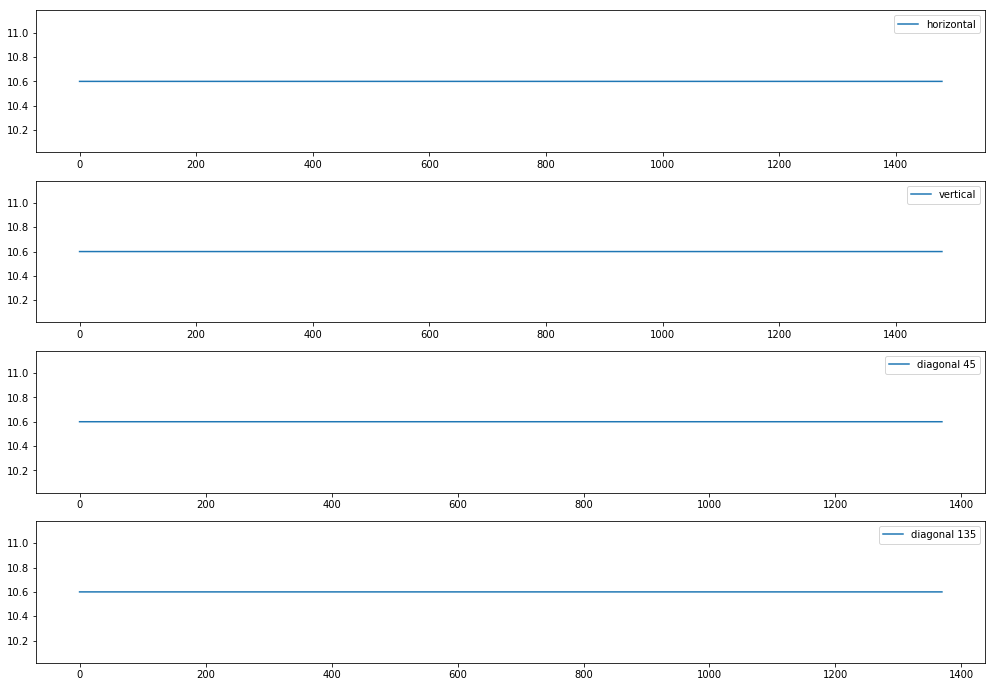

In [18]:
plot_preferred_distribution()

# TRAIN

In [19]:
previous_spike_count = np.zeros(n_L4)
input_groups['LGN_on'].rates = 0 * Hz
input_groups['LGN_off'].rates = 0 * Hz

for iteration in range(epochs*orientations):
    o_index = iteration%orientations
    
    if (o_index == h_index or o_index == v_index):
        num_epochs = r_length
        if (o_index == v_index):
            continue
    elif (o_index == d1_index or o_index == d2_index):
        num_epochs = r_length*2 - 2
        continue
    
    net.run(resting_time)
    
    for name, e_i in neuron_groups_list:
        if (e_i == 'e'):
            neuron_groups[name].theta = np.ones((n_L4)) * 20.0*mV

    j = 0
    while j < (num_epochs):
        p = j;
        q = j-1 if j%2 else j+1
        
        on_stimuli = get_stimuli_strip(p, o_index, (r_length,r_length))
        off_stimuli = get_stimuli_strip(q, o_index, (r_length,r_length))
        
        spike_rates_on = on_stimuli.reshape((n_LGN)) / 8. * input_intensity
        spike_rates_off = off_stimuli.reshape((n_LGN)) / 8. * input_intensity

        input_groups['LGN_on'].rates = spike_rates_on * Hz
        input_groups['LGN_off'].rates = spike_rates_off * Hz

        print('run example number:', j+1, 'of', num_epochs, 'in iteration', iteration, 'of', epochs*orientations)
        
        net.run(single_example_time, report='text')   # 0.35 s

        current_spike_count = np.asarray(spike_monitors['L4'].count[:]) - previous_spike_count
        previous_spike_count = np.copy(spike_monitors['L4'].count[:])
        
        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz
        net.run(resting_time) 
        
        j += 1
#         if np.sum(current_spike_count) < 1:
#             if (input_intensity == 5):
#                 break;
#             print("F - spike count", np.sum(current_spike_count))
#             input_intensity += 1
#         else:     
#             print("S - spike count", np.sum(current_spike_count))
#             input_intensity = start_input_intensity
#             j += 1
        
        # garbage collect after each iteration
        gc.collect()
    normalize_prefered_weights(o_index)

run example number: 1 of 44 in iteration 0 of 4
Starting simulation at t=250. ms for a duration of 0.45 s
0.1605214285714286 (35%) simulated in 10s, estimated 18s remaining.
0.45 (100%) simulated in 18s
run example number: 2 of 44 in iteration 0 of 4
Starting simulation at t=0.95 s for a duration of 0.45 s
0.09716785714285715 (21%) simulated in 10s, estimated 36s remaining.
0.45 (100%) simulated in 14s
run example number: 3 of 44 in iteration 0 of 4
Starting simulation at t=1.65 s for a duration of 0.45 s
0.05470714285714288 (12%) simulated in 10s, estimated 1m 12s remaining.
0.45 (100%) simulated in 16s
run example number: 4 of 44 in iteration 0 of 4
Starting simulation at t=2.35 s for a duration of 0.45 s
0.050046428571428554 (11%) simulated in 10s, estimated 1m 20s remaining.
0.45 (100%) simulated in 14s
run example number: 5 of 44 in iteration 0 of 4
Starting simulation at t=3.05 s for a duration of 0.45 s
0.032811428571428554 (7%) simulated in 10s, estimated 2m 7s remaining.
0.45 

0.45 (100%) simulated in 18s
run example number: 39 of 44 in iteration 0 of 4
Starting simulation at t=26.85 s for a duration of 0.45 s
0.0043500000000002885 (0%) simulated in 10s, estimated 17m 5s remaining.
0.45 (100%) simulated in 17s
run example number: 40 of 44 in iteration 0 of 4
Starting simulation at t=27.55 s for a duration of 0.45 s
0.004373035714286031 (0%) simulated in 10s, estimated 16m 59s remaining.
0.45 (100%) simulated in 17s
run example number: 41 of 44 in iteration 0 of 4
Starting simulation at t=28.25 s for a duration of 0.45 s
0.004039024390244185 (0%) simulated in 10s, estimated 18m 25s remaining.
0.45 (100%) simulated in 17s
run example number: 42 of 44 in iteration 0 of 4
Starting simulation at t=28.95 s for a duration of 0.45 s
0.003910714285714581 (0%) simulated in 10s, estimated 19m 1s remaining.
0.45 (100%) simulated in 17s
run example number: 43 of 44 in iteration 0 of 4
Starting simulation at t=29.65 s for a duration of 0.45 s
0.004067940199335844 (0%) sim

L3 v_min 0 v_max 7
L4 v_min 0 v_max 8


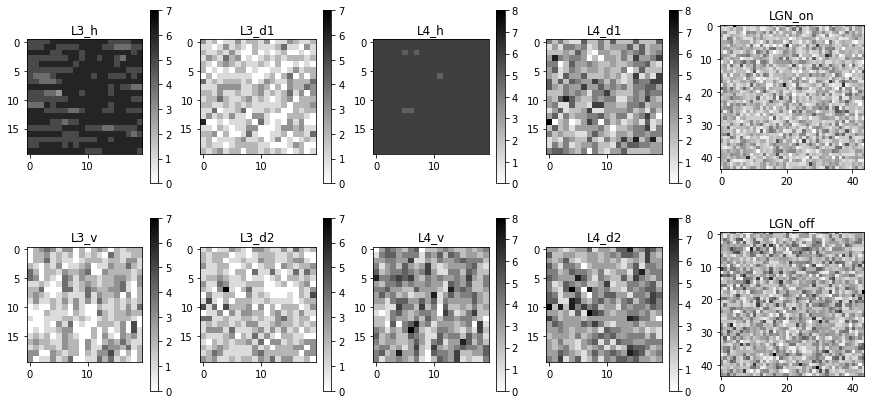

In [20]:
c_shape = (c_length, c_length, orientations)
r_shape = (r_length, r_length)
fig, axarr = subplots(2,5, figsize = (15, 7))

data = np.copy(spike_monitors['L3'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()
print('L3 v_min', v_min, 'v_max', v_max)

im3 = axarr[0,0].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,0].title.set_text('L3_h'); 
plt.colorbar(im3, ax=axarr[0,0])
im3 = axarr[1,0].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,0].title.set_text('L3_v'); 
plt.colorbar(im3, ax=axarr[1,0])
im3 = axarr[0,1].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,1].title.set_text('L3_d1');
plt.colorbar(im3, ax=axarr[0,1])
im3 = axarr[1,1].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,1].title.set_text('L3_d2');
plt.colorbar(im3, ax=axarr[1,1])


data = np.copy(spike_monitors['L4'].count).reshape(c_shape).transpose()
v_min = data.min(); v_max = data.max()
print('L4 v_min', v_min, 'v_max', v_max)

im4 = axarr[0,2].imshow(data[h_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,2].title.set_text('L4_h')
plt.colorbar(im4, ax=axarr[0,2])
im4 = axarr[1,2].imshow(data[v_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,2].title.set_text('L4_v')
plt.colorbar(im4, ax=axarr[1,2])
im4 = axarr[0,3].imshow(data[d1_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,3].title.set_text('L4_d1')
plt.colorbar(im4, ax=axarr[0,3])
im4 = axarr[1,3].imshow(data[d2_index].transpose(), vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,3].title.set_text('L4_d2')
plt.colorbar(im4, ax=axarr[1,3])


data = np.copy(spike_monitors['LGN_on'].count).reshape(r_shape)
v_min = data.min(); v_max = data.max()
axarr[0,4].imshow(data, vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[0,4].title.set_text('LGN_on')

data = np.copy(spike_monitors['LGN_off'].count).reshape(r_shape)
v_min = data.min(); v_max = data.max()
axarr[1,4].imshow(data, vmax=v_max, vmin=v_min, cmap = cmap.get_cmap('binary'))
axarr[1,4].title.set_text('LGN_off')

In [21]:
gc.collect()

20

horizontal  -  15958.912759740499
vertical  -  15725.21448345058
diagonal 45  -  14535.776208152287
diagonal 135  -  14539.034458683187


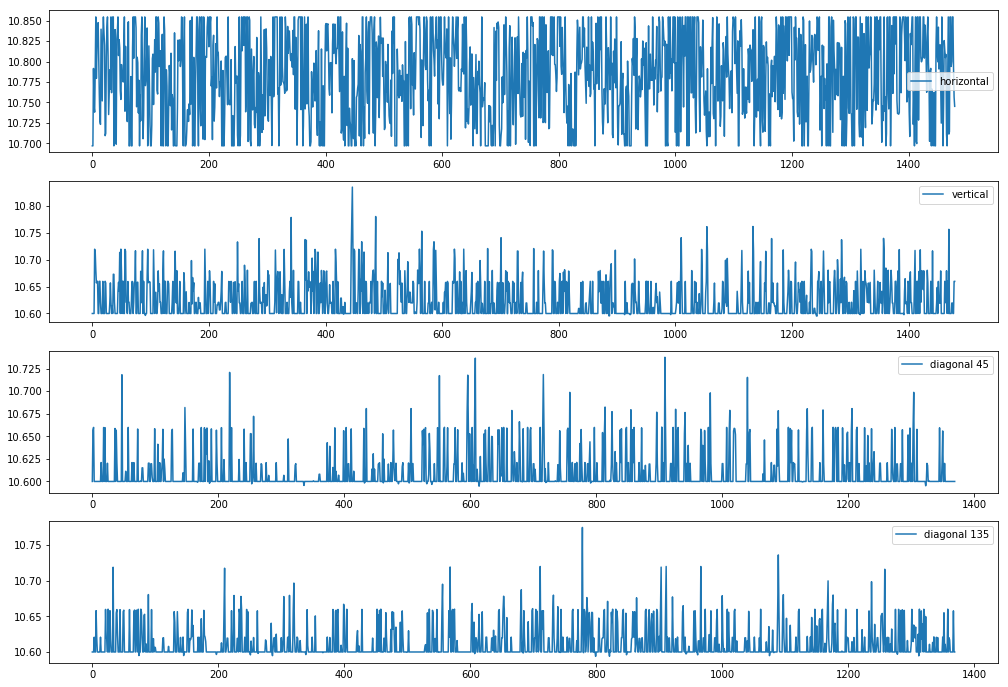

In [22]:
plot_preferred_distribution()

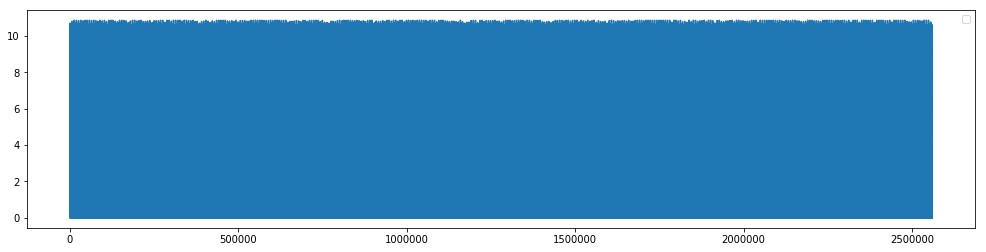

2235

In [23]:
weights = np.array(connections['L3_L3'].w)
weights = weights.reshape(n_L3*n_L3)
plt.figure(figsize=(17,4))
plt.plot(weights)
plt.legend(); plt.show()
gc.collect()

In [24]:
# save connections
# save_connections()

In [25]:
plot(spike_monitors['LGN_on'].t/ms, spike_monitors['input'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

KeyError: 'input'

In [ ]:
plot(spike_monitors['L4'].t/ms, spike_monitors['L4'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [ ]:
plot(spike_monitors['L3'].t/ms, spike_monitors['L3'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [ ]:
plot(spike_monitors['L2'].t/ms, spike_monitors['L2'].i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index');

In [ ]:
gc.collect()

In [ ]:
# figure(figsize=(15, 4))
# plot(M['L2'].t/ms, M['L2'].v[8], label='L2')
# plot(M['L3'].t/ms, M['L3'].v[8], label='L3')
# legend()